# Week 8 Workshop

In this week we are working with the protein language model ESM-2. The model family is available on HuggingFace: https://huggingface.co/facebook/esm2_t12_35M_UR50D

We can access and use the model easily using the `transformers` library: https://huggingface.co/docs/transformers/en/index

As always, we begin by importing the required dependencies.

In [132]:
import torch
import polars as pl
from tqdm import tqdm
import plotnine as pln
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, EsmForMaskedLM

Next we're loading the tokenizer and model.

**Note:** If the following code runs extremely slowly or errors out you may have to update your python installation. Alternatively, you can try to run it in a python console, not in Jupyter. Older versions of Jupyter have a bug that prevents this code from running correctly.

In [133]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t12_35M_UR50D")
model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=480, out_fe

## Exploring the β-lactamase dataset

We will be working with a deep mutational scanning dataset of the protein β-lactamase. The data comes from:

> Stiffler MA, Hekstra DR, Ranganathan R (2015). Evolvability as a function of purifying selection in TEM-1 β-lactamase. Cell 160:882-892. https://doi.org/10.1016/j.cell.2015.01.035

First we read the data.

In [134]:
data_complete = pl.read_csv('./data/B-Lactamase_Ranganathan2015.csv')
data_complete

ID,mutant,target,sequence,wt,site,mut
str,str,f64,str,str,i64,str
"""BLAT_Ran_H24C""","""H24C""",-0.41826,"""MSIQHFRVALIPFFAAFCLPVFACPETLVK…","""H""",24,"""C"""
"""BLAT_Ran_H24E""","""H24E""",-0.279024,"""MSIQHFRVALIPFFAAFCLPVFAEPETLVK…","""H""",24,"""E"""
"""BLAT_Ran_H24D""","""H24D""",-0.181607,"""MSIQHFRVALIPFFAAFCLPVFADPETLVK…","""H""",24,"""D"""
"""BLAT_Ran_H24G""","""H24G""",-0.060242,"""MSIQHFRVALIPFFAAFCLPVFAGPETLVK…","""H""",24,"""G"""
"""BLAT_Ran_H24F""","""H24F""",-0.818487,"""MSIQHFRVALIPFFAAFCLPVFAFPETLVK…","""H""",24,"""F"""
…,…,…,…,…,…,…
"""BLAT_Ran_W286S""","""W286S""",-2.967712,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""S"""
"""BLAT_Ran_W286R""","""W286R""",-2.707731,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""R"""
"""BLAT_Ran_W286T""","""W286T""",-2.806422,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""T"""


Let's look at the distribution of the `target` value, which represents the fitness of each mutant.

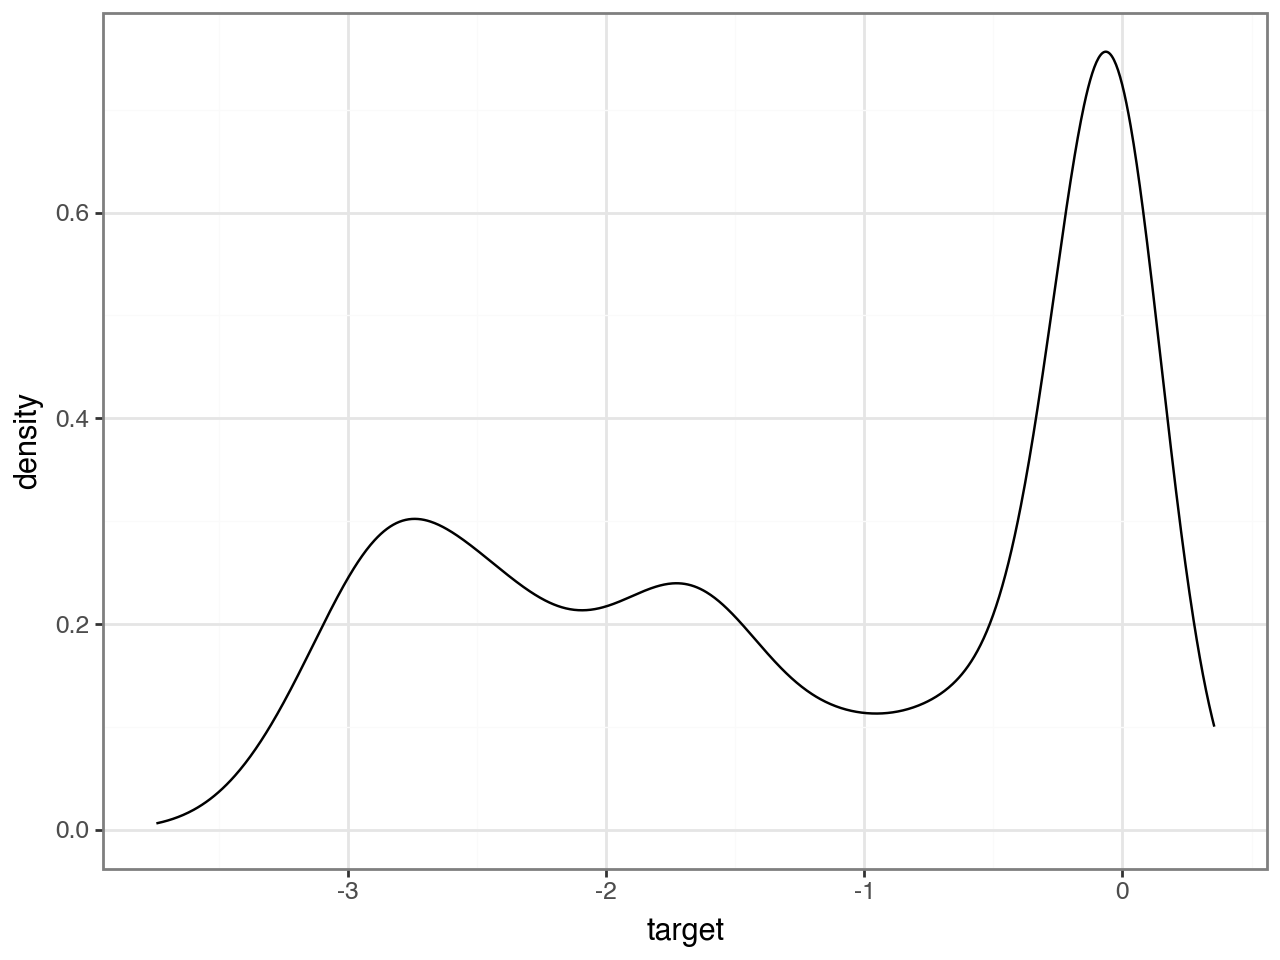

In [135]:
density_plot = (
    pln.ggplot(data_complete, pln.aes(x='target'))
    + pln.geom_density()
    + pln.theme_bw()
    )
density_plot.show()

The distribution is bi-modal. Let's say the enzyme has high activity for fitness values above -1 and low activity otherwise. We'll add an activity column to the data to express this.

In [136]:
data_complete = data_complete.with_columns(
    pl.when(pl.col('target') > -1)
      .then(pl.lit('high'))
      .otherwise(pl.lit('low'))
      .alias('activity')
)
data_complete

ID,mutant,target,sequence,wt,site,mut,activity
str,str,f64,str,str,i64,str,str
"""BLAT_Ran_H24C""","""H24C""",-0.41826,"""MSIQHFRVALIPFFAAFCLPVFACPETLVK…","""H""",24,"""C""","""high"""
"""BLAT_Ran_H24E""","""H24E""",-0.279024,"""MSIQHFRVALIPFFAAFCLPVFAEPETLVK…","""H""",24,"""E""","""high"""
"""BLAT_Ran_H24D""","""H24D""",-0.181607,"""MSIQHFRVALIPFFAAFCLPVFADPETLVK…","""H""",24,"""D""","""high"""
"""BLAT_Ran_H24G""","""H24G""",-0.060242,"""MSIQHFRVALIPFFAAFCLPVFAGPETLVK…","""H""",24,"""G""","""high"""
"""BLAT_Ran_H24F""","""H24F""",-0.818487,"""MSIQHFRVALIPFFAAFCLPVFAFPETLVK…","""H""",24,"""F""","""high"""
…,…,…,…,…,…,…,…
"""BLAT_Ran_W286S""","""W286S""",-2.967712,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""S""","""low"""
"""BLAT_Ran_W286R""","""W286R""",-2.707731,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""R""","""low"""
"""BLAT_Ran_W286T""","""W286T""",-2.806422,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""W""",286,"""T""","""low"""


Next we randomly down-sample to speed up the subsequent calculations. Set the fraction to 1 to work with the complete dataset.

In [137]:
target_fract = 0.1 # set to 1 to work with the complete dataset
data = data_complete.sample(fraction = target_fract, seed=8592153)
data.shape

(499, 8)

Let's see how many high and low activity mutants we have in the resulting dataset.

In [138]:
data['activity'].value_counts()

activity,count
str,u32
"""high""",251
"""low""",248


The data set is roughly balanced. We don't have to worry about class imbalances.

## Predicting mutant activity

We want to fit a classifier to distinguish between high activity and low activity mutants. To do this, we will first calculate embeddings, then do a PCA to reduce the embedding space, and then fit a logistic regression to the dimension-reduced embedding space. (We don't have enough data points to fit to the full space.)

First we calculate embeddings.

In [139]:
mean_representations = {}
with torch.no_grad():  # disable gradient calculations
    for seq_id, sequence in tqdm( # iterate using a nice progress bar
        data.select(['ID', 'sequence']).iter_rows(), 
        desc = "Processing sequences", 
        leave = False,
        total = len(data)
    ):
        # tokenize without padding or truncation
        tokens = tokenizer(sequence, return_tensors = "pt", padding = False, truncation = False)
        tokens = tokens.to(device)
        
        # get model output (hidden states are the embedding layers)
        output = model(tokens['input_ids'], output_hidden_states = True)
 
        # get the last hidden state
        # (Not the most efficient for larger datasets. For larger we should use batches.)
        embeddings = output.hidden_states[-1][0]  # Last layer, first and only sequence (batch size = 1)

        # extract the mean embeddings for the sequence, excluding [CLS] and [EOS]
        representations = embeddings[1:-1, :].detach().cpu()  
        
        # compute mean representation of the sequence
        mean_representations[seq_id] = representations.mean(dim=0)

# join emeddings and original data frame
embed = pl.DataFrame(mean_representations).transpose(include_header=True, header_name='ID')
embed_df = data.join(embed, on='ID')
embed_df

ID,mutant,target,sequence,wt,site,mut,activity,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,…,column_443,column_444,column_445,column_446,column_447,column_448,column_449,column_450,column_451,column_452,column_453,column_454,column_455,column_456,column_457,column_458,column_459,column_460,column_461,column_462,column_463,column_464,column_465,column_466,column_467,column_468,column_469,column_470,column_471,column_472,column_473,column_474,column_475,column_476,column_477,column_478,column_479
str,str,f64,str,str,i64,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""BLAT_Ran_E56Y""","""E56Y""",-1.791599,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""E""",56,"""Y""","""low""",0.008489,0.045989,0.035619,0.194355,-0.033782,-0.040241,-0.007707,0.041086,-0.060097,0.084335,-0.051786,-0.009364,-0.039023,0.035727,-0.140893,0.046024,0.036946,0.041085,-0.2722,-0.015444,0.092204,-0.007499,0.062542,-0.042806,-0.143874,0.139055,0.236807,0.06624,-0.03141,…,0.021434,0.161674,0.236477,-0.152158,0.110343,-0.064782,0.065849,-0.01317,-0.153681,-0.007734,0.071339,-0.021433,0.202764,-0.131389,-0.296762,0.050954,-0.024256,-0.380596,-0.108346,-0.070138,-0.125222,0.145879,-0.154392,-0.123019,-0.125179,0.146112,0.13639,-0.013542,0.077347,-0.021628,0.092062,0.146573,0.006191,-0.007422,-0.080424,0.05042,-0.162599
"""BLAT_Ran_E145K""","""E145K""",-0.034368,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""E""",145,"""K""","""high""",0.007397,0.03768,0.026352,0.205649,-0.033304,-0.038623,-0.009698,0.034497,-0.080014,0.083948,-0.06293,-0.004204,-0.031431,0.034178,-0.135176,0.054786,0.046543,0.044175,-0.25698,-0.01502,0.098998,-0.004189,0.0602,-0.054547,-0.147926,0.139948,0.224219,0.066533,-0.035864,…,0.027396,0.158112,0.242318,-0.150737,0.10967,-0.07215,0.053741,-0.012666,-0.165939,-0.010253,0.079716,-0.021489,0.192229,-0.152265,-0.29832,0.048273,-0.027461,-0.401042,-0.101574,-0.068508,-0.124014,0.143944,-0.171077,-0.131869,-0.109659,0.137221,0.131933,-0.002923,0.082906,-0.025599,0.100296,0.146505,0.008799,-0.007084,-0.082663,0.048986,-0.166951
"""BLAT_Ran_A266K""","""A266K""",-0.193697,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""A""",266,"""K""","""high""",0.003951,0.039621,0.038828,0.200154,-0.032685,-0.043832,-0.010444,0.033432,-0.079345,0.08516,-0.069183,0.00126,-0.02693,0.026765,-0.132169,0.048406,0.042749,0.04724,-0.259382,-0.012262,0.097579,0.007518,0.060969,-0.057196,-0.143723,0.136379,0.221042,0.064875,-0.040231,…,0.028507,0.156226,0.239262,-0.145655,0.111617,-0.072085,0.052913,-0.01005,-0.162198,-0.004581,0.077955,-0.018767,0.192487,-0.145845,-0.298486,0.052916,-0.028122,-0.41154,-0.098829,-0.073807,-0.119266,0.141086,-0.161486,-0.131553,-0.113844,0.137717,0.13166,-0.005482,0.083293,-0.019417,0.105161,0.146677,0.005277,-0.008114,-0.077374,0.040362,-0.160109
"""BLAT_Ran_G236V""","""G236V""",-3.008814,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""G""",236,"""V""","""low""",0.012743,0.043346,0.024933,0.204817,-0.030738,-0.032657,-0.011894,0.036808,-0.073722,0.087213,-0.068519,-0.004791,-0.032861,0.036599,-0.134456,0.052645,0.046211,0.038473,-0.256806,-0.015439,0.095727,-0.000196,0.064043,-0.053497,-0.142013,0.143636,0.222065,0.068123,-0.032889,…,0.025331,0.153487,0.240804,-0.141982,0.11497,-0.066752,0.050088,-0.011517,-0.159805,-0.00628,0.074876,-0.017836,0.194066,-0.150394,-0.301103,0.052493,-0.030696,-0.392465,-0.09691,-0.071292,-0.121683,0.144655,-0.169314,-0.124453,-0.109041,0.143977,0.131665,-0.011138,0.087837,-0.024535,0.100078,0.147101,0.003986,-0.006255,-0.079851,0.050807,-0.168451
"""BLAT_Ran_G76M""","""G76M""",-1.7

Next we do a PCA and visualize active and inactive mutants in PC space.

In [140]:
# select only the embedding columns (there are 480 for the 35M parameter model)
features = embed_df.select(pl.col([f'column_{str(i)}' for i in range(480)]))

# run PCA and extract 20 components
n_components = 20
X_pca  = PCA(n_components=n_components).fit_transform(features)

# create data frame of first two components for visualization
pca_df = pl.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Activity': embed_df['activity']
})
pca_df

PC1,PC2,Activity
f64,f64,str
0.059816,0.02159,"""low"""
-0.033795,-0.014873,"""high"""
0.014739,-0.008137,"""high"""
-0.041345,-0.009275,"""low"""
0.046515,-0.000263,"""low"""
…,…,…
-0.002538,0.003674,"""low"""
-0.03015,0.027813,"""low"""
0.011131,-0.041297,"""high"""


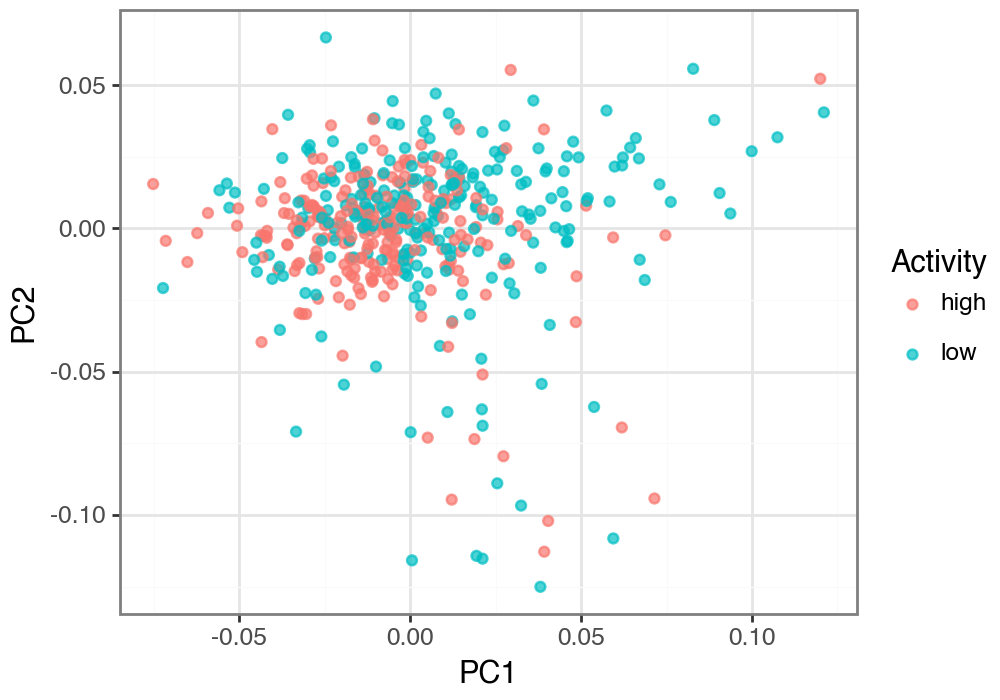

In [141]:
pca_plot = (
    pln.ggplot(pca_df, pln.aes(x='PC1', y='PC2', color='Activity'))
    + pln.geom_point(size=1.5, alpha=.7)
    + pln.theme_bw()
    + pln.theme(
        figure_size = (5, 3.5)
    )
)
pca_plot.show()

There seems to be some separation between high and low activity mutants. Let's see if a logistic regression on 20 PC dimensions can successfully classify the data.


Training samples: 399
Test samples: 100
Feature dimension for classification: 20

Training classifier on 20 principal components...

CLASSIFICATION RESULTS (using PCA components)
Training Accuracy: 69.67%
Test Accuracy: 60.00%

Test Set Classification Report:
              precision    recall  f1-score   support

         low       0.65      0.44      0.52        50
        high       0.58      0.76      0.66        50

    accuracy                           0.60       100
   macro avg       0.61      0.60      0.59       100
weighted avg       0.61      0.60      0.59       100

Test Set Confusion Matrix:
                  Predicted
               low        high
Actual low      22         28
       high     12         38


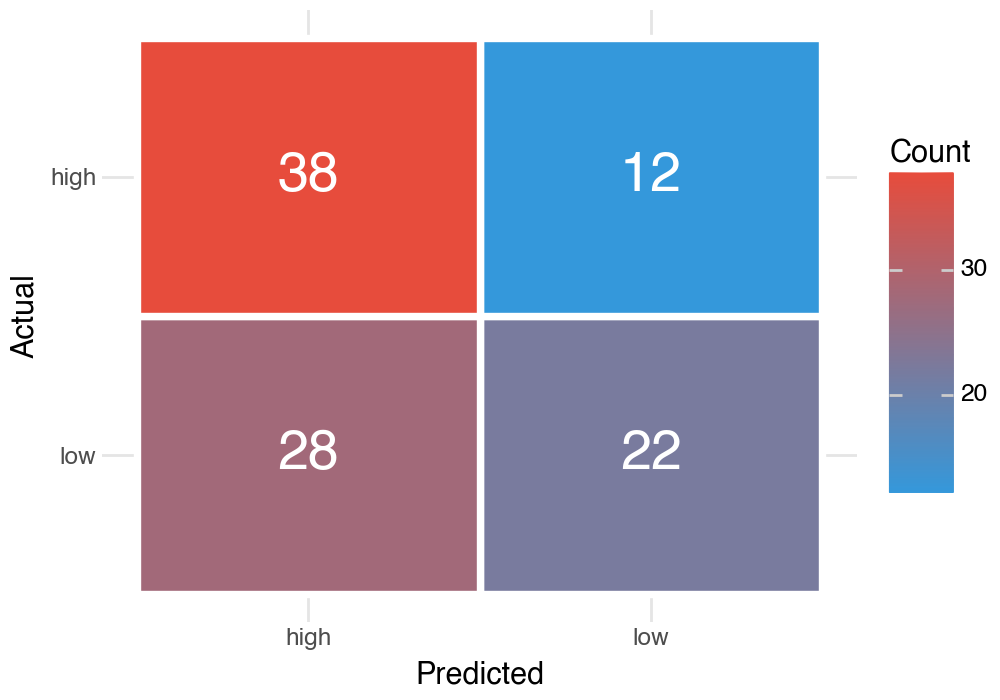

In [142]:
# first we create a numeric response variable
# 0 = 'low', 1 = 'high'
y = embed_df['activity'].replace({'low': 0, 'high': 1})

# now we create the training/test split
random_state = 16492345 # change for different train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size = 0.2, random_state = random_state, stratify = y
)
    
print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature dimension for classification: {X_train.shape[1]}")
    
# train logistic regression classifier on PCA components
print(f"\nTraining classifier on {n_components} principal components...")
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)
    
# make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
    
# evaluate performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
    
print(f"\n{'='*50}")
print("CLASSIFICATION RESULTS (using PCA components)")
print(f"{'='*50}")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
   
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, 
                            target_names = ['low', 'high']))
    
print("Test Set Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(f"                  Predicted")
print(f"               low        high")
print(f"Actual low     {cm[0,0]:3d}        {cm[0,1]:3d}")
print(f"       high    {cm[1,0]:3d}        {cm[1,1]:3d}")
    
# create confusion matrix visualization
cm_df = pl.DataFrame({
    'actual': ['low', 'low', 'high', 'high'],
    'predicted': ['low', 'high', 'low', 'high'],
    'count': [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
})
    
cm_plot = (
    pln.ggplot(cm_df, pln.aes(x = 'predicted', y = 'actual', fill = 'count'))
    + pln.geom_tile(color = 'white', size = 1.5)
    + pln.geom_text(pln.aes(label = 'count'), size = 20, color = 'white')
    + pln.scale_fill_gradient(low = '#3498db', high = '#e74c3c')
    + pln.scale_x_discrete(limits = ['high', 'low'])
    + pln.scale_y_discrete(limits = ['low', 'high'])
    + pln.labs(
        x='Predicted',
        y='Actual',
        fill='Count'
    )
    + pln.theme_minimal()
    + pln.theme(
        figure_size = (5, 3.5)
    )
)

cm_plot.show()

## Excercises

- Use more of the data than just 10% and see how this changes results
- Change the number of components in the PCA before classification
- Use a different random seed in the training/test split
- Use embeddings from different layers